# Discounting of Probabilistic Food Reinforcement by Pigeons

This notebook provides a complete Python-based replication of the analyses from the publication:

> Oliveira, L., Green, L., Myerson, J., & Wan, H. (2025). Discounting of probabilistic food reinforcement by pigeons. *Journal of the Experimental Analysis of Behavior, 124*(1). https://doi.org/10.1002/jeab.70042

The original R analysis (`brms`) is translated into a Python workflow using `pandas`, `pymc`, `arviz`, and `matplotlib`. The analysis uses Bayesian nonlinear multilevel models to fit a hyperboloid discounting function to pigeons' choices.

The data for this study are publicly available on the Open Science Framework at: <https://osf.io/scwg3/>.

### Workflow Overview

1.  **Setup**: Imports all necessary Python libraries and defines a custom plotting theme.
2.  **Data Processing**: Loads the raw data from both experiments, cleans and transforms it, and calculates the Area under the Curve (AuC) for each subject and condition.
3.  **Experiment 1**:
    * Fits a Bayesian multilevel hyperboloid model to the "certain vs. probabilistic" choice data.
    * Visualizes the model fits (Figure 1 replication).
    * Calculates Bayesian $R^2$ and replicates the AuC analysis (Table 1 & Figure 2 replication).
4.  **Experiment 2**:
    * Fits the generalized hyperboloid model to the "probabilistic vs. probabilistic" choice data for all 6 conditions.
    * Visualizes the model fits (Figures 3-5 replication).
    * Calculates Bayesian $R^2$ and replicates the AuC analysis (Table 2 replication).

In [11]:
# --- 1. Environment Setup ---
# This cell installs all the required Python packages.
# It is commented out by default. Uncomment and run this cell if the packages 
# are not yet installed in your environment.

# import sys
# !{sys.executable} -m pip install pandas numpy pymc arviz matplotlib seaborn scikit-learn openpyxl statsmodels jupyter

In [12]:
# --- 2. Imports, Settings, and Helper Functions ---

# --- Core Libraries ---
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf

# --- Modeling ---
import pymc as pm
import arviz as az
from sklearn.metrics import auc as calculate_trapezoid_auc

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Global Settings ---
# Suppress warnings for a cleaner notebook output
warnings.filterwarnings('ignore')
# Standardize float display format
pd.options.display.float_format = '{:.3f}'.format

# --- Custom function ---

# Define plot theme
def style_plot(ax: plt.Axes, title: str = ""):
    """
    Applies a consistent, publication-quality theme to a Matplotlib axes object.
    
    Args:
        ax (matplotlib.axes.Axes): The axes object to style.
        title (str): The title for the plot.
    """
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel(ax.get_xlabel(), fontsize=14, fontweight='bold')
    ax.set_ylabel(ax.get_ylabel(), fontsize=14, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=10, direction='out')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    ax.set_facecolor('white')
    ax.grid(False)
    if ax.get_legend():
        ax.get_legend().set_frame_on(False)

# Define AuC for a group
def calculate_auc_group(df: pd.DataFrame) -> float:
    """Helper function to calculate AuC for a group."""
    df = df.sort_values('OAs')
    # Normalize OAs to a 0-1 scale for AuC calculation
    # Add 0,0 point to anchor the curve if min OAs is not 0
    oas_vals = df['OAs']
    rsv_vals = df['RSV']
    if oas_vals.min() > 0:
        oas_vals = pd.concat([pd.Series([0]), oas_vals])
        rsv_vals = pd.concat([pd.Series([1]), rsv_vals]) # Assuming RSV=1 at OAs=0
        
    norm_oas = oas_vals / oas_vals.max()
    return calculate_trapezoid_auc(norm_oas, rsv_vals)

# Define functions for Experiment 1
def fit_model_exp1(model_data: pd.DataFrame) -> (az.InferenceData, pm.Model):
    """
    Fits the Bayesian hyperboloid model for Experiment 1.
    RSV = 1 / (1 + h * OAs)^s
    """
    coords = {"Subject": model_data['Subject'].cat.categories}
    with pm.Model(coords=coords) as model:
        # --- Define Data ---
        # Get integer codes for subject indices
        subject_idx = pd.Categorical(model_data['Subject'], categories=coords["Subject"]).codes
        # Create mutable data containers for PyMC
        oas_data = pm.Data("oas_data", model_data['OAs'].values)
        subject_idx_data = pm.Data("subject_idx_data", subject_idx)
        
        # --- Priors ---
        # Using 'h' for the rate param to match user's R code
        h = pm.TruncatedNormal("h", mu=1, sigma=10, lower=0, dims="Subject")
        s = pm.TruncatedNormal("s", mu=1, sigma=10, lower=0, dims="Subject")
        # 'nu' is the precision parameter (phi in brms/paper)
        nu = pm.HalfCauchy("nu", beta=10, dims="Subject")

        # --- Model Definition (Equation 1) ---
        mu = 1 / (1 + h[subject_idx_data] * oas_data)**s[subject_idx_data]
        
        # --- Likelihood ---
        # Use Beta regression for proportional RSV data
        pm.Beta("RSV", mu=mu, nu=nu[subject_idx_data], observed=model_data['RSV'].values)
        
        # --- Sampling ---
        idata = pm.sample(draws=2000, tune=2000, chains=4, cores=4, progressbar=False, target_accept=0.95)
    return idata, model

def get_predictions_exp1(idata: az.InferenceData, amount_val: int) -> pd.DataFrame:
    """
    Generates median posterior predictions for Experiment 1 models.
    """
    # Extract posterior draws for parameters
    post_h = az.extract(idata, var_names=["h"])
    post_s = az.extract(idata, var_names=["s"])
    
    pred_df_list = []
    # Iterate through each subject in the model
    for subj in idata.posterior.Subject.values:
        # Create a smooth grid of OAs values for plotting
        oas_grid = np.linspace(0, 10, 100)
        
        # Get the median parameter estimates for this subject
        h_med = post_h.sel(Subject=subj).median().item()
        s_med = post_s.sel(Subject=subj).median().item()
        
        # Calculate predicted RSV using the hyperboloid formula
        pred_rsv = 1 / (1 + h_med * oas_grid)**s_med
        
        pred_df_list.append(pd.DataFrame({
            'Subject': subj, 'OAs': oas_grid, '.epred': pred_rsv
        }))
    
    # Combine predictions for all subjects
    pred_df = pd.concat(pred_df_list)
    pred_df['Amount'] = f"{amount_val} Pellets"
    return pred_df

def calculate_r2_exp1(model: pm.Model, idata: az.InferenceData, model_data: pd.DataFrame) -> pd.Series:
    """Calculates Bayesian R-squared for each subject in an Experiment 1 model."""
    with model:
        # Set data to the full dataset for this model
        pm.set_data({
            "oas_data": model_data['OAs'].values,
            "subject_idx_data": pd.Categorical(model_data['Subject'], categories=model.coords['Subject']).codes
        })
        # Generate ONE posterior predictive sample
        post_pred = pm.sample_posterior_predictive(idata, var_names=["RSV"], random_seed=42, progressbar=False)

    # Calculate median prediction for each observation
    epred = post_pred.posterior_predictive['RSV'].median(dim=("chain", "draw")).values

    # Add predictions to a copy of the dataframe
    results_df = model_data.copy()
    results_df['.epred'] = epred
    results_df['residual'] = results_df['RSV'] - results_df['.epred']

    # Calculate Sum of Squares Residual (ss_res) for each subject
    ss_res = results_df.groupby('Subject', observed=True)['residual'].apply(lambda x: (x**2).sum())

    # Calculate Sum of Squares Total (ss_tot) for each subject
    def ss_total(x):
        return ((x - x.mean())**2).sum()
    ss_tot = results_df.groupby('Subject', observed=True)['RSV'].apply(ss_total)

    # Calculate R2 for each subject
    r2_series = 1 - (ss_res / ss_tot)
    return r2_series

def get_param_summary(idata: az.InferenceData, amount: int) -> pd.DataFrame:
    """Extracts parameter estimates (mean, sd) for each subject."""
    summary = az.summary(idata, var_names=['h', 's'], kind='stats')
    summary['Subject'] = summary.index.str.split('[').str[1].str.replace(']', '')
    summary['Parameter'] = summary.index.str.split('[').str[0]
    summary['Amount'] = amount
    return summary[['Subject', 'Amount', 'Parameter', 'mean', 'sd']]

# Define functions for Experiment 2
def fit_model_exp2(model_data: pd.DataFrame) -> (az.InferenceData, pm.Model):
    """
    Fits the Bayesian generalized hyperboloid model for Experiment 2.
    RSV = ((1 + h * OAs_Sm)^s) / ((1 + h * OAs)^s)
    """
    subjects_in_data = model_data['Subject'].cat.categories
    coords = {"Subject": subjects_in_data}
    
    with pm.Model(coords=coords) as model:
        # --- Define Data ---
        subject_idx = pd.Categorical(model_data['Subject'], categories=coords["Subject"]).codes
        # Create mutable data containers
        oas_data = pm.Data("oas_data", model_data['OAs'].values)
        oas_sm_data = pm.Data("oas_sm_data", model_data['OAs_Sm'].values)
        subject_idx_data = pm.Data("subject_idx_data", subject_idx)
        
        # --- Priors ---
        h = pm.TruncatedNormal("h", mu=1, sigma=10, lower=0, dims="Subject")
        s = pm.TruncatedNormal("s", mu=1, sigma=10, lower=0, dims="Subject")
        nu = pm.HalfCauchy("nu", beta=10, dims="Subject")
        
        # --- Model Definition (Equation 2) ---
        mu = ((1 + h[subject_idx_data] * oas_sm_data)**s[subject_idx_data]) / \
             ((1 + h[subject_idx_data] * oas_data)**s[subject_idx_data])
        
        # --- Likelihood ---
        pm.Beta("RSV", mu=mu, nu=nu[subject_idx_data], observed=model_data['RSV'].values)
        
        # --- Sampling ---
        idata = pm.sample(draws=2000, tune=2000, chains=4, cores=4, progressbar=False, target_accept=0.95) 
    
    return idata, model

def get_predictions_exp2(idata: az.InferenceData, amount_val: int, mult_val: float, model_data: pd.DataFrame) -> pd.DataFrame:
    """Generates median predictions for Experiment 2 models."""
    post_h = az.extract(idata, var_names=["h"])
    post_s = az.extract(idata, var_names=["s"])
    
    pred_df_list = []
    subjects_in_model = idata.posterior.Subject.values
    
    for subj in subjects_in_model:
        # Create a grid of OAs for prediction
        oas_grid = np.linspace(
            model_data['OAs'].min(), model_data['OAs'].max(), 100
        )
        # Get the single OAs_Sm value for this condition
        oas_sm_val = model_data['OAs_Sm'].iloc[0]

        # Get median parameter estimates
        h_med = post_h.sel(Subject=subj).median().item()
        s_med = post_s.sel(Subject=subj).median().item()
        
        # Calculate predicted RSV using the Exp 2 formula (Eq. 2)
        pred_rsv = ((1 + h_med * oas_sm_val)**s_med) / ((1 + h_med * oas_grid)**s_med)
        
        pred_df_list.append(pd.DataFrame({
            'Subject': subj, 'OAs': oas_grid, '.epred': pred_rsv
        }))
    
    pred_df = pd.concat(pred_df_list)
    pred_df['Amount'] = f"{amount_val} Pellets"
    pred_df['Multiplier'] = mult_val
    return pred_df

def calculate_r2_exp2(model: pm.Model, idata: az.InferenceData, model_data: pd.DataFrame) -> pd.Series:
    """Calculates Bayesian R-squared for each subject in an Experiment 2 model."""
    with model:
        # Set all required mutable data
        pm.set_data({
            "oas_data": model_data['OAs'].values,
            "oas_sm_data": model_data['OAs_Sm'].values,
            "subject_idx_data": pd.Categorical(model_data['Subject'], categories=model.coords['Subject']).codes
        })
        post_pred = pm.sample_posterior_predictive(idata, var_names=["RSV"], random_seed=42, progressbar=False)

    epred = post_pred.posterior_predictive['RSV'].median(dim=("chain", "draw")).values
    
    results_df = model_data.copy()
    results_df['.epred'] = epred
    results_df['residual'] = results_df['RSV'] - results_df['.epred']

    ss_res = results_df.groupby('Subject', observed=True)['residual'].apply(lambda x: (x**2).sum())
    ss_tot = results_df.groupby('Subject', observed=True)['RSV'].apply(lambda x: ((x - x.mean())**2).sum())
    
    r2_series = 1 - (ss_res / ss_tot)
    # Set negative R2 values to NaN as they indicate poor fit
    r2_series[r2_series < 0] = np.nan
    return r2_series

## Data Loading & Processing

This section loads the raw data for both experiments from the OSF repository, processes them into a single, analysis-ready DataFrame, and calculates the Area under the Curve (AuC) for each subject and condition.

In [13]:
# --- 3. Data Loading and Processing ---

# --- Load OSF Data ---
raw_data_exp1 = pd.read_csv("PigeonPD_Exp1.csv", dtype={'Probability': 'str'})
raw_data_exp2 = pd.read_csv("PigeonPD_Exp2.csv", dtype={'Multiplier': 'str'})
print("Data loaded successfully.")

# --- Process Experiment 1 Data ---
processed_data_exp1 = raw_data_exp1.assign(
    Experiment=1,
    Rep=lambda x: x['Probability'].str.contains("R").astype(int),
    Prob_Lg=lambda x: x['Probability'].str.replace("R", "").astype(float) / 100,
    OAs=lambda x: (1 - x['Prob_Lg']) / x['Prob_Lg'],
    RSV=lambda x: x['SV'] / x['Amount'],
    Multiplier=1.0,
    OAs_Sm=0
).filter(items=['Subject', 'Experiment', 'Multiplier', 'Amount', 'Rep', 'OAs', 'RSV', 'OAs_Sm', 'Prob_Lg'])

# --- Process Experiment 2 Data ---
processed_data_exp2 = raw_data_exp2.assign(
    Experiment=2,
    Rep=lambda x: x['Multiplier'].str.contains("R").astype(int),
    Multiplier=lambda x: x['Multiplier'].str.replace("R", "").astype(float),
    Prob_Lg=lambda x: x['Probability_Lg'] / 100,
    Prob_Sm=lambda x: x['Probability_Sm'] / 100,
    OAs=lambda x: (1 - x['Prob_Lg']) / x['Prob_Lg'],
    OAs_Sm=lambda x: (1 - x['Prob_Sm']) / x['Prob_Sm'],
    RSV=lambda x: x['SV'] / x['Amount']
).filter(items=['Subject', 'Experiment', 'Multiplier', 'Amount', 'Rep', 'OAs', 'RSV', 'OAs_Sm', 'Prob_Lg'])

# --- Combine Data & Create Mean Subject ---
combined_data = pd.concat([processed_data_exp1, processed_data_exp2])

mean_data = combined_data[combined_data['Rep'] == 0].groupby(
    ['Experiment', 'Amount', 'Multiplier', 'OAs', 'Prob_Lg', 'OAs_Sm'], as_index=False
)['RSV'].mean().assign(Subject="Mean", Rep=0)

# Set Subject as categorical with 'Mean' last
subject_levels = ["P41","P42","P43","P44","P45","P46","P47","P48","Mean"]
combined_data['Subject'] = pd.Categorical(
    combined_data['Subject'], categories=subject_levels, ordered=True
)
# Clip RSV for Beta regression, which requires the outcome to be in the open interval (0, 1)
combined_data['RSV'] = np.clip(combined_data['RSV'], 1e-6, 1 - 1e-6)

# --- Create AuC Dataframe ---
auc_data = combined_data[combined_data['Rep'] == 0].groupby(
    ['Subject', 'Experiment', 'Multiplier', 'Amount']
).apply(calculate_auc_group).reset_index(name='AuC')

Data loaded successfully.


## Experiment 1: Certain vs. Probabilistic Rewards

In Experiment 1, pigeons chose between a smaller, certain reinforcer (Odds Against = 0) and a larger, probabilistic reinforcer. The following section fits the hyperboloid discounting model (Equation 1) to the data for each amount (16 and 32 pellets).

In [14]:
# --- Experiment 1: Bayesian Model Fitting ---

# --- Fit models for each amount ---
print("Fitting Experiment 1 models...")
# 16-Pellet Model
data_exp1_16p = combined_data[(combined_data.Experiment == 1) & (combined_data.Rep == 0) & (combined_data.Amount == 16)]
idata_exp1_16, model_exp1_16 = fit_model_exp1(data_exp1_16p)

# 32-Pellet Model
data_exp1_32p = combined_data[(combined_data.Experiment == 1) & (combined_data.Rep == 0) & (combined_data.Amount == 32)]
idata_exp1_32, model_exp1_32 = fit_model_exp1(data_exp1_32p)

print("Experiment 1 model fitting complete.")

Fitting Experiment 1 models...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h, s, nu]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h, s, nu]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 12 seconds.


Experiment 1 model fitting complete.


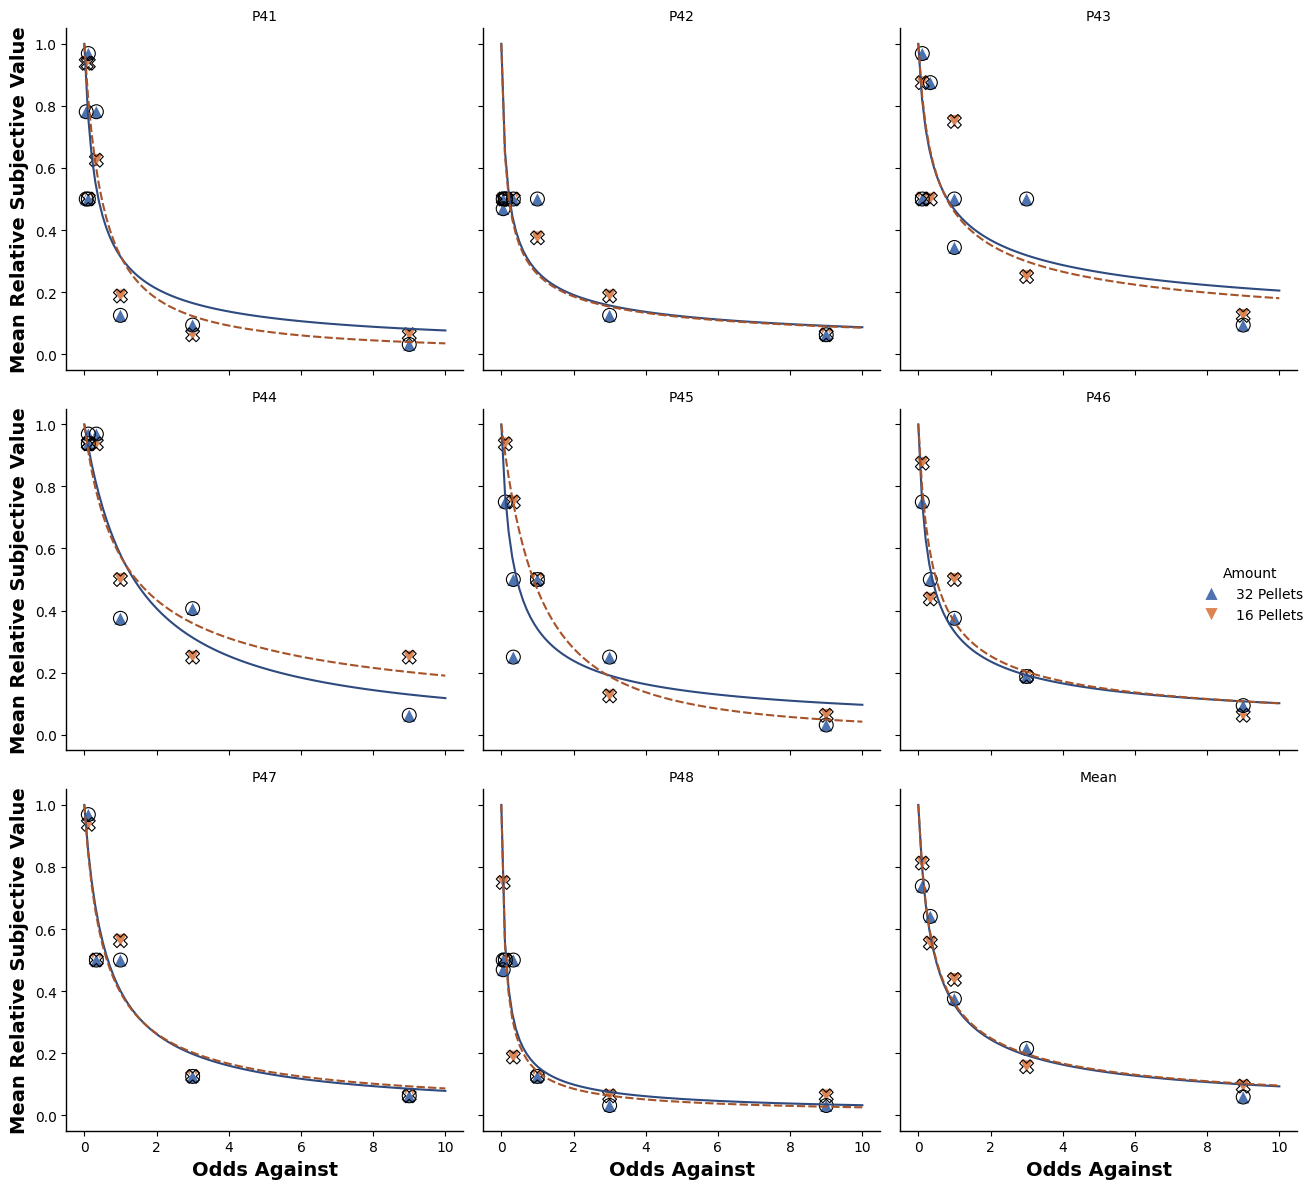

In [15]:
# --- Experiment 1: Plotting Results (Figure 1 Replication) ---

# --- Generate prediction curves for both models ---
pred_curves_exp1 = pd.concat([
    get_predictions_exp1(idata_exp1_16, 16),
    get_predictions_exp1(idata_exp1_32, 32)
])
pred_curves_exp1['Amount'] = pd.Categorical(pred_curves_exp1['Amount'], categories=["32 Pellets", "16 Pellets"])


# --- Create the FacetGrid Plot ---
plot_data_exp1 = combined_data[(combined_data.Experiment == 1)].copy()
plot_data_exp1['Amount'] = pd.Categorical(plot_data_exp1['Amount'].replace({16: "16 Pellets", 32: "32 Pellets"}),
                                          categories=["32 Pellets", "16 Pellets"])

# Define colors and markers
palette_fill = {"16 Pellets": "#DD8452", "32 Pellets": "#4C72B0"}
palette_line = {"16 Pellets": "#A65329", "32 Pellets": "#2E4A7F"}
markers = {"16 Pellets": "v", "32 Pellets": "^"}
linestyles = {"16 Pellets": "solid", "32 Pellets": (0, (5, 5))} # 'solid' and 'dashed'

# 1. Initialize the FacetGrid
g = sns.FacetGrid(plot_data_exp1, col="Subject", col_wrap=3, height=4, aspect=1)

# 2. Map the scatterplot for the observed data (Rep == 0)
g.map_dataframe(sns.scatterplot, x='OAs', y='RSV', hue='Amount', style='Amount', s=100,
                data=plot_data_exp1[plot_data_exp1.Rep == 0],
                palette=palette_fill, markers=markers,
                hue_order=["32 Pellets", "16 Pellets"], style_order=["32 Pellets", "16 Pellets"])

# 3. Map the scatterplot for the replication data (Rep == 1, open symbols)
g.map_dataframe(sns.scatterplot, x='OAs', y='RSV', style='Amount', s=100,
                data=plot_data_exp1[plot_data_exp1.Rep == 1],
                marker='o', facecolors='none', edgecolors='black',
                style_order=["32 Pellets", "16 Pellets"], legend=False)

# 4. Iterate through axes to overlay prediction lines
for subject, ax in g.axes_dict.items():
    line_data = pred_curves_exp1[pred_curves_exp1.Subject == subject]
    sns.lineplot(
        data=line_data,
        x='OAs',
        y='.epred',
        hue='Amount',
        style='Amount',
        ax=ax,
        palette=palette_line,
        hue_order=["32 Pellets", "16 Pellets"],
        style_order=["32 Pellets", "16 Pellets"],
        legend=False  # Turn off legend for lines to avoid duplicates
    )
    style_plot(ax) # Apply custom theme

g.set_titles("{col_name}")
g.set_axis_labels("Odds Against", "Mean Relative Subjective Value")
g.add_legend(title="Amount")
g.set(ylim=(-0.05, 1.05), xlim=(-0.5, 10.5))
plt.tight_layout()
plt.show()

In [ ]:
# --- Experiment 1: Results and Amount Effect (Table 1 & Figure 2 Replication) ---

# --- Calculate and Display R-squared ---
print("--- Experiment 1: Bayesian R-squared by Subject ---")
r2_16 = calculate_r2_exp1(model_exp1_16, idata_exp1_16, data_exp1_16p)
r2_32 = calculate_r2_exp1(model_exp1_32, idata_exp1_32, data_exp1_32p)

r2_table = pd.DataFrame({'R2_16p': r2_16, 'R2_32p': r2_32})
print(r2_table)
print(f"\nMedian R2 (16 Pellets): {r2_16.median():.3f}")
print(f"Median R2 (32 Pellets): {r2_32.median():.3f}")

# --- Parameter Table (Replicates Table 1) ---
params_summary_exp1 = pd.concat([get_param_summary(idata_exp1_16, 16), get_param_summary(idata_exp1_32, 32)])
params_table_exp1 = params_summary_exp1.pivot(index=['Subject', 'Amount'], columns='Parameter', values=['mean', 'sd'])
print("\n--- Parameter Estimates (Replicates Table 1) ---")
print(params_table_exp1)

# --- Amount Effect on AuC (GEE Model) ---
print("\n--- Amount Effect on AuC (GEE) ---")
auc_data_exp1 = auc_data[(auc_data.Experiment == 1) & (auc_data.Subject != 'Mean')].copy()
auc_data_exp1['Amount_cat'] = auc_data_exp1['Amount'].astype('category')

# Use Generalized Estimating Equations (GEE) to account for repeated measures (by Subject)
# This is a Python equivalent to R's glmmTMB/lme4 for this type of test.
# We use a Binomial family as AuC is bounded [0, 1] (similar to Beta regression)
gee_model = smf.gee(
    "AuC ~ C(Amount_cat, Treatment(reference=16))", 
    "Subject",
    data=auc_data_exp1, 
    family=sm.families.Binomial()
).fit()
print(gee_model.summary())
print("No significant effect of Amount on AuC was found (p > .05).")

Sampling: [RSV]


--- Experiment 1: Bayesian R-squared by Subject ---


Sampling: [RSV]


         R2_16p  R2_32p
Subject                
P41       0.966   0.636
P42       0.316   0.065
P43       0.720   0.302
P44       0.907   0.876
P45       0.990   0.875
P46       0.872   0.988
P47       0.883   0.904
P48       0.960   0.639
Mean      0.976   0.973

Median R2 (16 Pellets): 0.907
Median R2 (32 Pellets): 0.875

--- Parameter Estimates (Replicates Table 1) ---
                 mean          sd      
Parameter           h     s     h     s
Subject Amount                         
Mean    16      4.949 0.674 3.384 0.298
        32      5.084 0.699 3.600 0.500
P41     16      2.547 1.445 2.683 1.132
        32      6.151 0.849 5.103 0.732
P42     16     14.981 0.520 6.404 0.142
        32     13.841 0.530 6.259 0.162
P43     16      6.348 0.603 5.192 0.863
        32      7.882 0.510 5.991 0.626
P44     16      2.845 0.957 3.504 1.382
        32      1.891 2.065 3.076 2.893
P45     16      1.065 2.142 1.674 1.893
        32      6.415 0.687 4.649 0.544
P46     16      5.537 0.7

## Experiment 2: Two Probabilistic Rewards

In Experiment 2, the probabilities of both options were reduced by a common multiplier (1.0, 0.75, or 0.25), creating choices where both outcomes were probabilistic. This section fits the generalized hyperboloid model (Equation 2).

In [17]:
# --- Experiment 2: Bayesian Model Fitting ---

# --- Fit all 6 models for Experiment 2 ---
filtered_data_exp2 = combined_data[(combined_data.Experiment == 2) & (combined_data.Rep == 0)].copy()
filtered_data_exp2['Subject'] = filtered_data_exp2['Subject'].cat.remove_unused_categories()

# Create dictionaries to store the fitted models and their inference data
idata_exp2 = {}
models_exp2 = {}

for amt in [16, 32]:
    for mult in [1.0, 0.75, 0.25]:
        key = f"amt{amt}_mult{int(mult*100)}"
        print(f"Fitting {key}...")
        
        # Filter data for this specific condition
        data_subset = filtered_data_exp2[
            (filtered_data_exp2.Amount == amt) & (filtered_data_exp2.Multiplier == mult)
        ].copy()
        data_subset['Subject'] = data_subset['Subject'].cat.remove_unused_categories()

        # Fit the model and store both idata and the model object
        idata_obj, model_obj = fit_model_exp2(data_subset)
        idata_exp2[key] = idata_obj
        models_exp2[key] = model_obj

print("Experiment 2 model fitting complete.")

Fitting amt16_mult100...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h, s, nu]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 24 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...


Fitting amt16_mult75...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h, s, nu]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 15 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...


Fitting amt16_mult25...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h, s, nu]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.
There were 116 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...


Fitting amt32_mult100...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h, s, nu]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 23 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.


Fitting amt32_mult75...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h, s, nu]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...


Fitting amt32_mult25...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h, s, nu]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Experiment 2 model fitting complete.


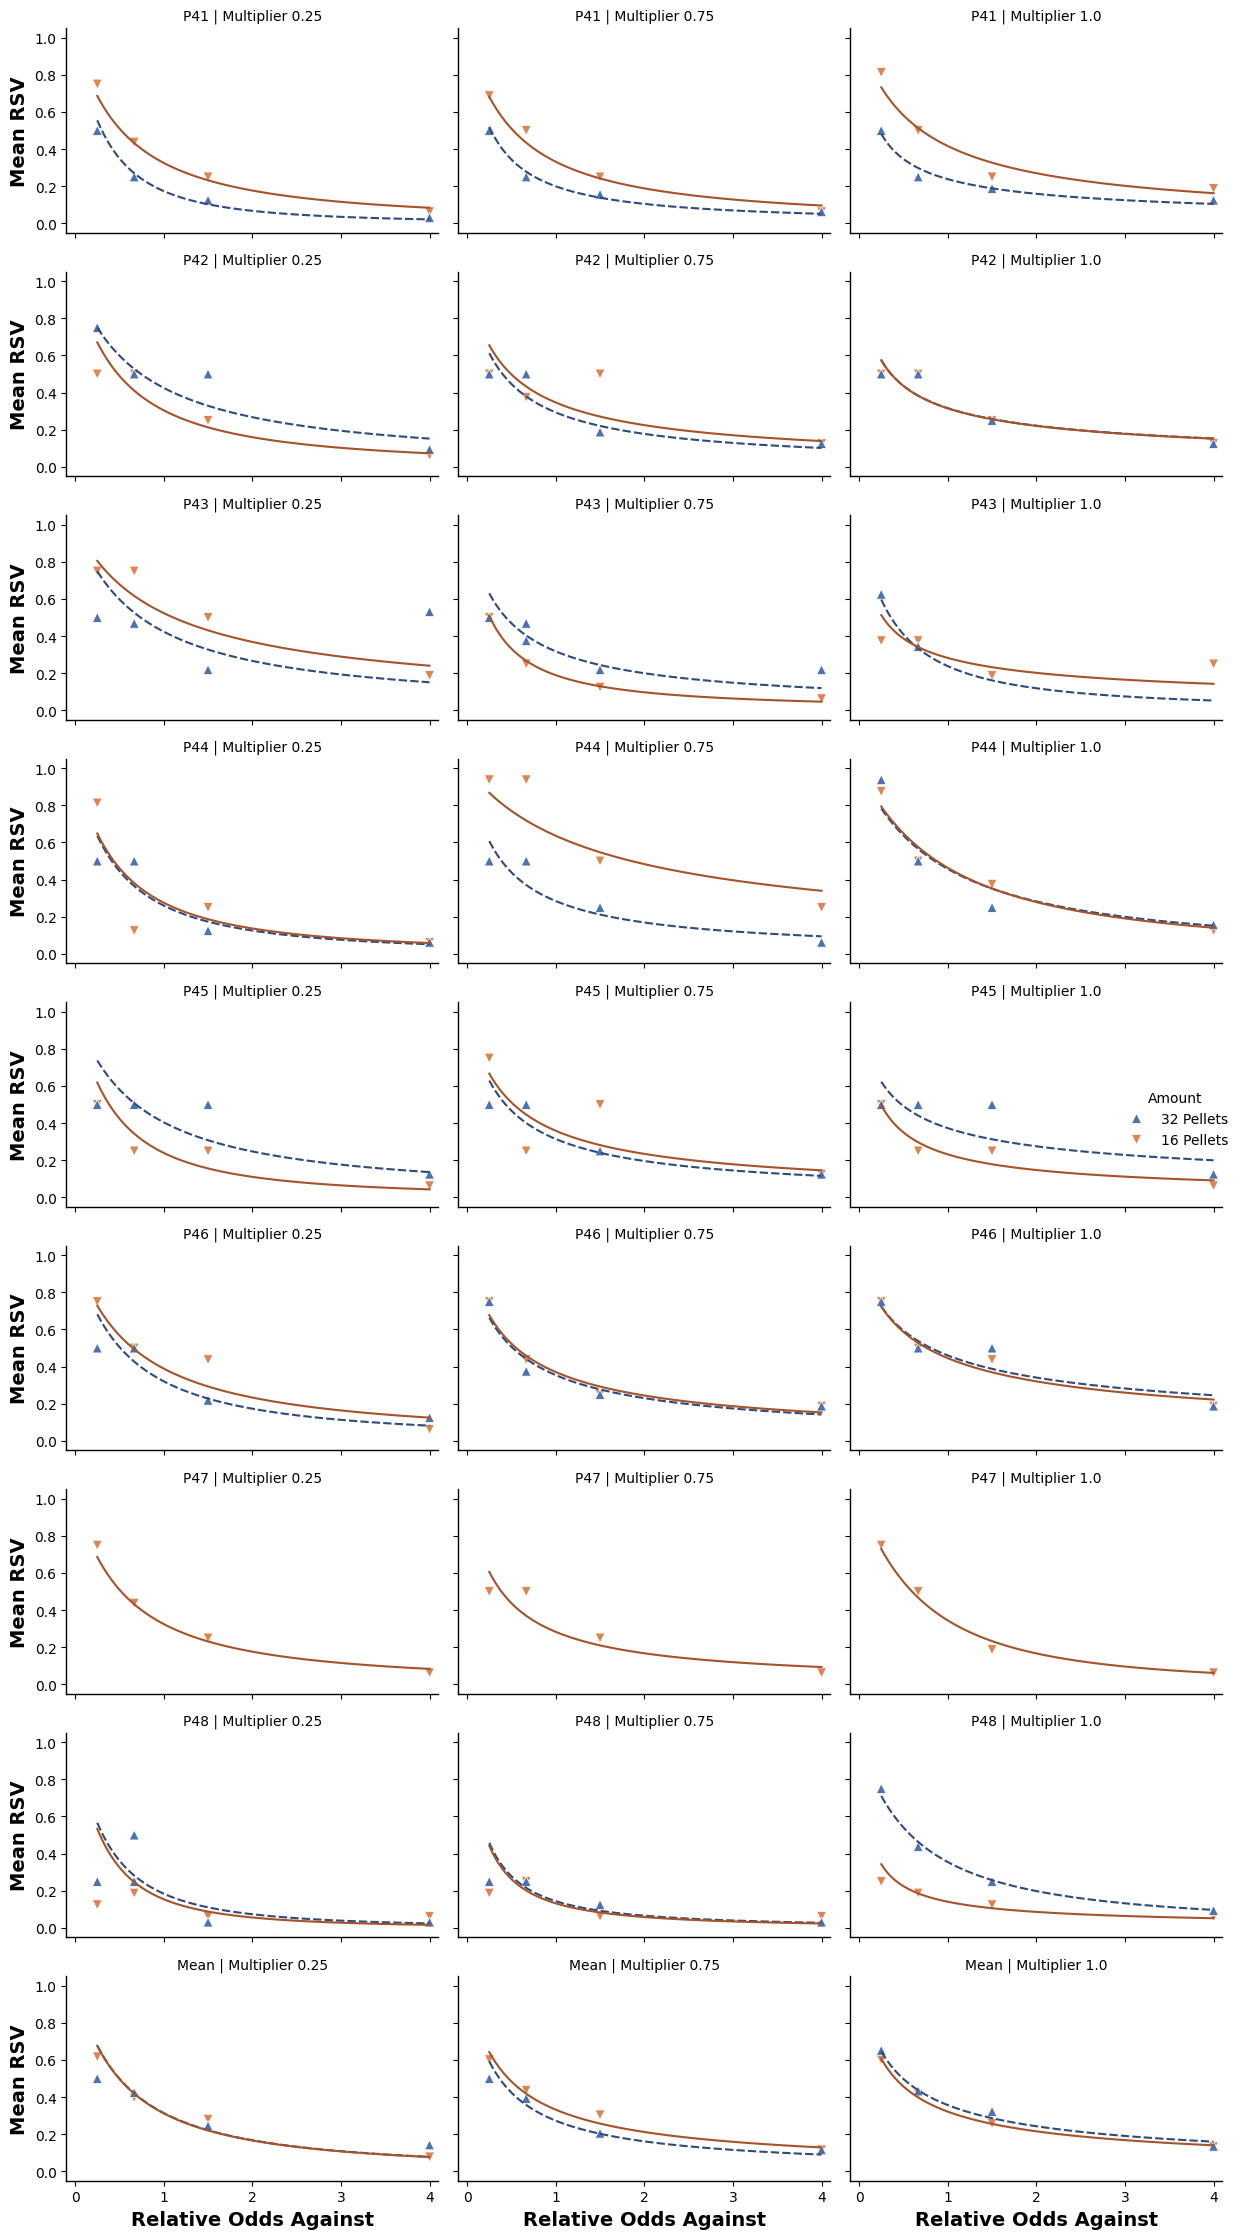

In [18]:
# --- Experiment 2: Plotting Results (Figures 3-5 Replication) ---

# --- Generate predictions for all 6 models ---
pred_curves_list_exp2 = []
for (key, idata_obj) in idata_exp2.items():
    amt = 16 if 'amt16' in key else 32
    mult = 1.0 if 'mult100' in key else (0.75 if 'mult75' in key else 0.25)
    data_subset = filtered_data_exp2[(filtered_data_exp2.Amount == amt) & (filtered_data_exp2.Multiplier == mult)]
    pred_curves_list_exp2.append(get_predictions_exp2(idata_obj, amt, mult, data_subset))

pred_curves_exp2 = pd.concat(pred_curves_list_exp2)

# --- Prepare data for plotting ---
# Calculate "Relative Odds Against" (Rel_OAs) for the x-axis
# This normalizes the OAs across multiplier conditions
def calculate_rel_oas(row):
    prob = 1 / (row['OAs'] + 1)
    rel_prob = prob / row['Multiplier']
    return (1 - rel_prob) / rel_prob

# Apply to observed data
plot_data_exp2 = combined_data[combined_data.Experiment == 2].copy()
plot_data_exp2['Rel_OAs'] = plot_data_exp2.apply(calculate_rel_oas, axis=1)
plot_data_exp2['Amount'] = pd.Categorical(plot_data_exp2['Amount'].replace({16: "16 Pellets", 32: "32 Pellets"}))
plot_data_exp2['Multiplier_Label'] = pd.Categorical(plot_data_exp2['Multiplier'].replace({1.0: "Multiplier 1.0", 0.75: "Multiplier 0.75", 0.25: "Multiplier 0.25"}))

# Apply to prediction data
pred_curves_exp2['Rel_OAs'] = pred_curves_exp2.apply(calculate_rel_oas, axis=1)
pred_curves_exp2['Amount'] = pd.Categorical(pred_curves_exp2['Amount'])
pred_curves_exp2['Multiplier_Label'] = pd.Categorical(pred_curves_exp2['Multiplier'].replace({1.0: "Multiplier 1.0", 0.75: "Multiplier 0.75", 0.25: "Multiplier 0.25"}))


# --- Create the FacetGrid Plot ---
g = sns.FacetGrid(plot_data_exp2, 
                  row="Subject", col="Multiplier_Label", 
                  height=2.5, aspect=1.5,
                  sharex=True, sharey=True, 
                  row_order=subject_levels) # Use the defined subject order

# Map the scatterplot of observed data
g.map_dataframe(sns.scatterplot, x='Rel_OAs', y='RSV', hue='Amount', style='Amount', s=50,
                palette=palette_fill, markers=markers,
                hue_order=["32 Pellets", "16 Pellets"])

# Iterate over axes to overlay prediction lines
for (row_val, col_val), ax in g.axes_dict.items():
    line_data = pred_curves_exp2[(pred_curves_exp2.Subject == row_val) & (pred_curves_exp2.Multiplier_Label == col_val)]
    sns.lineplot(
        data=line_data,
        x='Rel_OAs',
        y='.epred',
        hue='Amount',
        style='Amount',
        ax=ax,
        palette=palette_line,
        hue_order=["32 Pellets", "16 Pellets"],
        legend=False
    )
    style_plot(ax) # Apply custom theme
    ax.set_xticks(range(0, 5, 1)) # Set x-ticks 0, 1, 2, 3, 4

g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.set_axis_labels("Relative Odds Against", "Mean RSV")
g.add_legend(title="Amount")
g.set(ylim=(-0.05, 1.05), xlim=(-0.1, 4.1))
g.fig.tight_layout()
plt.show()

In [20]:
# --- Experiment 2: Results and Amount Effect (Table 2 Replication) ---

# --- Calculate R2 for all conditions ---
r2_list_exp2 = []
for (key, model_obj) in models_exp2.items():
    idata_obj = idata_exp2[key]
    amt = 16 if 'amt16' in key else 32
    mult = 1.0 if 'mult100' in key else (0.75 if 'mult75' in key else 0.25)
    data_subset = filtered_data_exp2[(filtered_data_exp2.Amount == amt) & (filtered_data_exp2.Multiplier == mult)]
    
    r2_series = calculate_r2_exp2(model_obj, idata_obj, data_subset)
    r2_df = r2_series.reset_index(name='R2')
    r2_df['Amount'] = amt
    r2_df['Multiplier'] = mult
    r2_list_exp2.append(r2_df)

r2_table_exp2 = pd.concat(r2_list_exp2)
print("--- Experiment 2: Bayesian R-squared by Condition ---")
print(r2_table_exp2.pivot_table(index=['Subject', 'Amount'], columns='Multiplier', values='R2'))


# --- Test for Amount Effect on AUC ---
print("\n--- Experiment 2: Amount Effect on AuC by Multiplier (GEE) ---")
auc_data_exp2 = auc_data[(auc_data.Experiment == 2) & (auc_data.Subject != 'Mean')].copy()

for m in [1.0, 0.75, 0.25]:
    print(f"\n--- Multiplier: {m} ---")
    data_subset = auc_data_exp2[auc_data_exp2.Multiplier == m].copy()
    
    if data_subset['Amount'].nunique() > 1:
        # Use GEE to test for an effect of Amount, clustering by Subject
        gee_model = smf.gee(
            "AuC ~ C(Amount, Treatment(reference=16))", 
            "Subject",
            data=data_subset, 
            family=sm.families.Binomial()
        ).fit()
        print(gee_model.summary())
    else:
        print(f"Only one amount level present for Multiplier {m}; cannot perform comparison.")

print("No significant effect of Amount on AuC was found in any condition (all p > .05).")

Sampling: [RSV]
Sampling: [RSV]
Sampling: [RSV]
Sampling: [RSV]
Sampling: [RSV]
Sampling: [RSV]


--- Experiment 2: Bayesian R-squared by Condition ---
Multiplier      0.250  0.750  1.000
Subject Amount                     
P41     16      0.990  0.985  0.950
        32      0.961  0.981  0.958
P42     16      0.673  0.016  0.801
        32      0.852  0.727  0.812
P43     16      0.887  0.993    NaN
        32        NaN  0.457  0.995
P44     16      0.739  0.869  0.956
        32      0.753  0.757  0.902
P45     16      0.612  0.569  0.911
        32        NaN  0.704  0.387
P46     16      0.903  0.957  0.959
        32      0.589  0.921  0.890
P47     16      0.989  0.759  0.988
P48     16        NaN    NaN  0.544
        32        NaN    NaN  0.990
Mean    16      0.941  0.962  0.998
        32      0.434  0.861  0.987

--- Experiment 2: Amount Effect on AuC by Multiplier (GEE) ---

--- Multiplier: 1.0 ---
                               GEE Regression Results                              
Dep. Variable:                         AuC   No. Observations:                   15
Model